Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [96]:
import meshio
import numpy as np

import ufl
from dolfinx import fem, io, common
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells, compute_collisions)

import convex_return_mapping as crm
import basix
import sys
sys.path.append("../")
import fenicsx_support as fs

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

# defining function to interpolate function defined over quadrature elements
def interpolate_quadrature(ufl_expr, fem_func):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    fem_func.x.scatter_forward()

In [97]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [98]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [99]:
# elastic parameters
sig0_dim = 70e3 #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim #[-]
nu = 0.3 #[-]
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))

sig0 = 250 / sig0_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [100]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
WTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(4, 4), quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)
WT = fem.FunctionSpace(mesh, WTe)

In [101]:
sig = fem.Function(W)
sig_old = fem.Function(W)
p = fem.Function(W0, name="Cumulative_plastic_strain")
p_old = fem.Function(W0, name="Cumulative_plastic_strain")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
C_tang = fem.Function(WT)

deps = fem.Function(W, name="deps")

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

In [102]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [103]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

SQRT2 = np.sqrt(2.)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def eps_vec(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_vector([e[0, 0], e[1, 1], 0, SQRT2 * e[0, 1]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3] / SQRT2, 0],
                          [X[3] / SQRT2, X[1], 0],
                          [0, 0, X[2]]])       

In [104]:
vonMises = crm.vonMises(sig0, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)

n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

N = patch_size = 3 # or batch, or group ?
N_patches = int(n_quadrature_points/patch_size)
residue_size = n_quadrature_points % patch_size

return_mapping = crm.ReturnMapping(material, patch_size)

p_values = p.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
p_old_values = p_old.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
deps_values = deps.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_values = sig.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_old_values = sig_old.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
C_tang_values = C_tang.x.array[:4*4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4, 4))

if residue_size != 0:
    return_mapping_residue = crm.ReturnMapping(material, residue_size)
    
    p_values_residue = p.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    p_old_values_residue = p_old.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    deps_values_residue = deps.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_values_residue = sig.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_old_values_residue = sig_old.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    C_tang_values_residue = C_tang.x.array[4*4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4, 4))

In [105]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps_vec(v), ufl.dot(C_tang, eps_vec(u_)))*dx 
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

def project(original_field, target_field, bcs=[]):
    # original_field -> target_field
    # Ensure we have a mesh and attach to measure
    V = target_field.function_space

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = fem.form(ufl.inner(Pv, w) * dx)
    L = fem.form(ufl.inner(original_field, w) * dx)

    # Assemble linear system
    A = fem.petsc.assemble_matrix(a, bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)
    fem.petsc.apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_field.vector)  
    target_field.x.scatter_forward()


In [106]:
problem = fem.petsc.LinearProblem(
    a_Newton,
    res,
    bcs=bcs,
    petsc_options={
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

form_res = fem.form(res)
form_a_Newton = fem.form(a_Newton)

b = fem.petsc.create_vector(form_res)
A = fem.petsc.create_matrix(form_a_Newton)

with b.localForm() as b_local:
    b_local.set(0.0)
fem.petsc.assemble_vector(b, form_res)
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
fem.set_bc(b, bcs)

A.zeroEntries()
fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
A.assemble()

solver = PETSc.KSP().create(mesh.comm)
solver.setType("preonly")
solver.getPC().setType("lu")
solver.setOperators(A)

In [107]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u

cells = []
points_on_proc = []
x_point = np.zeros((1, 3))
x_point[0][0] = Ri
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
cell_candidates = compute_collisions(tree, x_point)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, x_point)
for i, point in enumerate(x_point):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [108]:
def error_norm1(uh, u):
    return np.sum(np.abs(u - uh)) / np.sum(np.abs(u))

def error_norm2(uh, u):
    return np.sqrt(np.dot(u - uh, u - uh)) / np.sqrt(np.dot(u, u))

C_fake = fem.Function(WT)
for i in range(n_quadrature_points):
    C_fake.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

In [109]:
# def return_mapping_local(return_mapping:crm.ReturnMapping, time_logging_local, deps:fem.function.Function = deps, sig:fem.function.Function = sig, sig_old:fem.function.Function = sig_old, p:fem.function.Function = p, p_old:fem.function.Function = p_old, C_tang:fem.function.Function = C_tang):
#     return_mapping.deps.value[:] = deps.x.array.reshape((-1, N, 4))[q,:].T
#     return_mapping.sig_old.value[:] = sig_old.x.array.reshape((-1, N, 4))[q,:].T
#     return_mapping.p_old.value = p_old.x.array.reshape((-1, N))[q,:]
    
#     return_mapping.solve(derivation=True, verbose=False, eps=1e-13) #, alpha=1, scale=5.
#     time_logging_local['convex_solving'][q] = return_mapping.convex_solving_time
#     time_logging_local['convex_solving_cvxpy'][q] = return_mapping.opt_problem._solve_time
#     time_logging_local['differentiation'][q] = return_mapping.differentiation_time

#     sig.x.array.reshape((-1, N, 4))[q,:] = return_mapping.sig.value[:].T
#     p.x.array.reshape((-1, N))[q,:] = return_mapping.p.value

#     C_tang.x.array.reshape((-1, N, 4, 4))[q,:] = return_mapping.C_tang[:]

In [110]:
Nitermax, tol = 200, 1e-7  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
load_steps = load_steps
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
p_old.vector.set(0.0)
u.vector.set(0.0)

n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C
# T.vector.norm - bug, where T is a tensor???

logging_parts = ['convex_solving', 'convex_solving_cvxpy', 'differentiation', 'return_mapping', 'differentiation_total', 'convex_solving_total']
main_logging_parts = ['convex_solving', 'convex_solving_cvxpy', 'differentiation']

time_logging = {}
time_logging_local = {}
for part in logging_parts: 
    time_logging[part] = np.zeros((Nincr))
    time_logging_local[part] = np.zeros((n_quadrature_points))

mosek_params = {'MSK_DPAR_INTPNT_CO_TOL_DFEAS' : 1.0e-13}

with common.Timer() as timer: 
    for (i, t) in enumerate(load_steps):
        time_logging_tmp = {}
        for part in logging_parts: 
            time_logging_tmp[part] = []

        loading.value = t * q_lim

        with b.localForm() as b_local:
            b_local.set(0.0)
        b = fem.petsc.assemble_vector(form_res)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.set_bc(b, bcs)

        nRes0 = b.norm() # Which one? - ufl.sqrt(Res.dot(Res))
        nRes = nRes0
        # Du.vector.set(0.0)
        # Du.x.scatter_forward()
        Du.x.array[:] = 0

        if MPI.COMM_WORLD.rank == 0:
            print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
        niter = 0

        while nRes/nRes0 > tol and niter < Nitermax:
            solver.solve(b, du.vector)
            print('du', np.max(du.x.array), np.min(du.x.array), du.vector.norm())

            Du.vector.axpy(1, du.vector) # Du = Du + 1*du
            Du.x.scatter_forward() 

            with common.Timer() as timer_return_mapping: 
                interpolate_quadrature(eps_vec(Du), deps) # eps_xy * sqrt(2.)!

                for q in range(N_patches):
                    return_mapping.deps.value[:] = deps_values[q,:].T
                    return_mapping.sig_old.value[:] = sig_old_values[q,:].T
                    return_mapping.p_old.value = p_old_values[q,:]
                    
                    return_mapping.solve(derivation=True, verbose=False, eps=1e-13) #, alpha=1, scale=5.
                    time_logging_local['convex_solving'][q] = return_mapping.convex_solving_time
                    time_logging_local['convex_solving_cvxpy'][q] = return_mapping.opt_problem._solve_time
                    time_logging_local['differentiation'][q] = return_mapping.differentiation_time

                    sig_values[q,:] = return_mapping.sig.value[:].T
                    p_values[q,:] = return_mapping.p.value
                    C_tang_values[q,:] = return_mapping.C_tang[:]

                if residue_size != 0: #how to improve ?
                    return_mapping_residue.deps.value[:] = deps_values_residue[0,:].T
                    return_mapping_residue.sig_old.value[:] = sig_old_values_residue[0,:].T
                    return_mapping_residue.p_old.value = p_old_values_residue[0,:]
                    
                    return_mapping_residue.solve(derivation=True, verbose=False, eps=1e-13) #, alpha=1, scale=5.
                    
                    sig_values_residue[0,:] = return_mapping_residue.sig.value[:].T
                    p_values_residue[0,:] = return_mapping_residue.p.value
                    C_tang_values_residue[0,:] = return_mapping_residue.C_tang[:]

                time_logging_tmp['return_mapping'].append(timer_return_mapping.elapsed()[0])

            for part in main_logging_parts:
                time_logging_tmp[part].append(np.mean(time_logging_local[part]))

            time_logging_tmp['convex_solving_total'].append(np.sum(time_logging_local['convex_solving']))
            time_logging_tmp['differentiation_total'].append(np.sum(time_logging_local['differentiation']))

            print('C_tang', np.max(C_tang.x.array), np.min(C_tang.x.array))
            print('C_tang relative error', error_norm1(C_tang.x.array, C_fake.x.array), error_norm2(C_tang.x.array, C_fake.x.array))

            A.zeroEntries()
            fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
            A.assemble()
            with b.localForm() as b_local:
                b_local.set(0.0)
            fem.petsc.assemble_vector(b, form_res)

            b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
            fem.set_bc(b, bcs)

            nRes = b.norm() 
            if MPI.COMM_WORLD.rank == 0:
                print(f"    Residual: {nRes}")
            niter += 1
        u.vector.axpy(1, Du.vector) # u = u + 1*Du
        u.x.scatter_forward()

        # p.vector.copy(p_old.vector)
        # p.x.scatter_forward()
        p_old.x.array[:] = p.x.array

        print('p after copy', np.max(p.x.array), np.min(p.x.array), p.vector.norm())
        
        # sig.vector.copy(sig_old.vector)
        # sig.x.scatter_forward()
        sig_old.x.array[:] = sig.x.array


        # project(p, p_avg)
        # p_avg.x.scatter_forward()
        
        # xdmf.write_function(u, t)
        # xdmf.write_function(p_avg, t)

        for part in logging_parts:
            time_logging[part][i] = np.mean(time_logging_tmp[part])

        for part in logging_parts:
            print(f'\trank#{MPI.COMM_WORLD.rank}: Time ({part}) = {np.mean(time_logging[part][i]):.5f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving per q (solve_time)) = {np.mean(time_logging[str][i]):.6f} (s)')

        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving per q) = {convex_solving_times[i]:.6f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean differentiation per q) = {differentiation_times[i]:.6f} (s)')
        # print(f'\trank#{MPI.COMM_WORLD.rank}: Time (mean return mapping) = {return_mapping_times[i]:.3f} (s)')
        # print(f'\t\trank#{MPI.COMM_WORLD.rank}: Time (mean convex solving) = {np.mean(convex_solving_total_time):.3f} (s) - {np.mean(convex_solving_total_time)/return_mapping_times[i]*100:.1f}%')
        # print(f'\t\trank#{MPI.COMM_WORLD.rank}: Time (mean differentiation) = {np.mean(differentiation_total_time):.3f} (s) - {np.mean(differentiation_total_time)/return_mapping_times[i]*100:.1f}%')

        if len(points_on_proc) > 0:
            results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)
    

# xdmf.close()

    print(f'\nrank#{MPI.COMM_WORLD.rank}: Time = {timer.elapsed()[0]:.3f} (s)')
    
    important_logging_parts = ['return_mapping', 'differentiation_total', 'convex_solving_total']
    for part in important_logging_parts:
        print(f'\trank#{MPI.COMM_WORLD.rank}: Time ({part}) = {np.sum(time_logging[part]):.3f} (s)')


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.346153846153845 -1.385690519923303e-08
C_tang relative error 3.524958390180334e-09 4.507273433160922e-09
    Residual: 7.350540377431972e-16
p after copy 7.694529716358323e-18 8.490047458393111e-19 0.0
	rank#0: Time (convex_solving) = 0.00175 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00083 (s)
	rank#0: Time (differentiation) = 0.00917 (s)
	rank#0: Time (return_mapping) = 2.28081 (s)
	rank#0: Time (differentiation_total) = 1.89879 (s)
	rank#0: Time (convex_solving_total) = 0.36295 (s)

nRes0 , 3.688449012011855e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.00041177877967277856 0.0 0.004957556646660604
C_tang 1.3461538461538396 -2.7730820336601398e-08
C_tang relative error 6.907500922106464e-09 8.970410392388045e-09
    Residual: 9.938144639955788e-13
p after copy 7.354664365454652e-12 3.736495132667795e-18 0.0
	rank#0: Time (convex_solving) =

TypeError: M_operator(): incompatible function arguments. The following argument types are supported:
    1. (arg0: scipy.sparse.csc_matrix[numpy.float64], arg1: List[_diffcp.Cone], arg2: numpy.ndarray[numpy.float64[m, 1]], arg3: numpy.ndarray[numpy.float64[m, 1]], arg4: float) -> _diffcp.LinearOperator

Invoked with: <67x67 sparse matrix of type '<class 'numpy.float64'>'
	with 220 stored elements in COOrdinate format>, [<_diffcp.Cone object at 0x7f7782e3caf0>, <_diffcp.Cone object at 0x7f7782e3c6f0>, <_diffcp.Cone object at 0x7f7782e352b0>, <_diffcp.Cone object at 0x7f7782e35530>, <_diffcp.Cone object at 0x7f7782e350b0>], array([ 1.30415551e-14,  1.30415551e-14,  1.30415551e-14, -7.06008399e-16,
        3.62379108e-17,  3.62540096e-17,  3.62439931e-17,  7.47827765e-04,
        5.26796363e-04,  3.82387239e-04, -9.08748690e-04,  6.75670453e-04,
        5.97416829e-04,  3.81926184e-04, -9.22083474e-04,  7.18178499e-04,
        5.40891352e-04,  3.77720955e-04, -9.98903262e-04,  1.79163223e-03,
        1.87098387e-03,  1.87576426e-03]), array([-3.62377147e-17, -3.62538375e-17, -3.62441167e-17, -1.37713619e-03,
       -1.27995067e-03, -1.27409592e-03, -3.50000000e-01, -1.65000000e+00,
        4.21627434e-21, -1.22179898e-17,  1.56016316e-16, -7.86143683e-18,
       -3.50000000e-01, -1.65000000e+00,  8.77259746e-21, -6.02062755e-17,
        1.06813837e-16, -3.44266777e-17, -3.50000000e-01, -1.65000000e+00,
        1.05390603e-20,  8.78294563e-18,  9.38453337e-17,  6.05109744e-18,
       -9.94949495e-01, -1.00505051e+00, -3.65498294e-17, -3.65722528e-17,
       -3.65665901e-17, -1.79163223e-03, -1.95490643e-04,  2.55407589e-05,
        1.69949884e-04,  9.08748690e-04, -1.87098387e-03, -1.23999297e-04,
       -4.57456736e-05,  1.69744971e-04,  9.22083474e-04, -1.87576426e-03,
       -1.72581563e-04,  4.70558322e-06,  1.67875980e-04,  9.98903262e-04]), array([1])

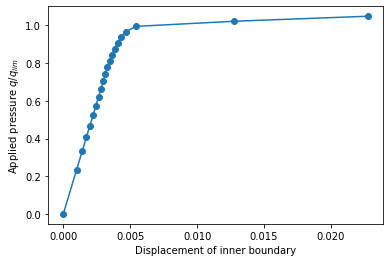

In [ ]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()